In [1]:
import os
import pandas as pd
import numpy as np
import datetime
import re
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import shutil

from datetime import datetime
import pytz

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

%matplotlib inline
%config InlineBackend.figure_format='retina'

localtime = pytz.timezone('Europe/London')

# Dataset Preparation

In [2]:
def process_strain_files(foldersearchpath): 
    """
    Process the strain files.

    Parameters:
    foldersearchpath (str): The path of the folder containing the modular rig files.

    Returns:
    - df_strain (DataFrame): The processed data from the Beta2 strain logger script.
    """
    dfs = []
    df_strain = pd.DataFrame()
    strain_files = []
    for filename in glob.glob(foldersearchpath + f'B2Strain-*.csv'):
        strain_files.append(filename)
    
    for filename in strain_files:
        df = pd.read_csv(filename)
        df.rename(columns={'Time(s)': 'timestamp'}, inplace=True)
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        df.set_index('timestamp', inplace=True)
        df.sort_index(inplace=True)
        df.rename(columns={
            'm1ai0': 'strain1',
            'm1ai6': 'strain2',
            'm1ai7': 'strain3',
            'm2ai5': 'strain4',
            'm2ai6': 'strain5',
            'm3ai5': 'strain6',
            'm3ai6': 'strain7',
            'm3ai7': 'strain8'}, inplace=True)
        #df['filename'] = os.path.basename(filename)
        dfs.append(df)
    
    df_strain = pd.concat(dfs)

    return df_strain

In [3]:
def process_HyTEST_files(foldersearchpath):
    """
    Process the files from HyTEST. The data obtained as of 12072024 are TEMPORARY, there is still
    no fixed storage for the .csv files and their structure (both in the filename and columns). 
    This function has to be modified accordingly.

    Parameters:
    foldersearchpath (str): The path of the folder containing the HyTEST rig files.

    Returns:
    - df_HyTEST (DataFrame): The processed data from the HyTEST (Beta2) rig.
    """
    dfs = []
    df_HyTEST = pd.DataFrame()
    HyTEST_files = []
    for filename in glob.glob(foldersearchpath + f'data-*.csv'):
        HyTEST_files.append(filename)

    for filename in HyTEST_files:
        df = pd.read_csv(filename)
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
        df.set_index('timestamp', inplace=True)
        df.sort_index(inplace=True, ascending=True)
        df['filename'] = os.path.basename(filename)
        dfs.append(df)

    df_HyTEST = pd.concat(dfs)

    return df_HyTEST    

In [4]:
def merge_dataframes(df_HyTEST, df_strain):
    """
    Merge the dataframes based on the timestamps in df_HyTEST.

    Parameters:
    - df_HyTEST (DataFrame): DataFrame containing modular rig data.
    - df_strain (DataFrame): DataFrame containing strain data.

    Returns:
    - df_full (DataFrame): Merged DataFrame.
    """
    df_HyTEST.sort_index(inplace=True)
    df_strain.sort_index(inplace=True)
    df = pd.merge_asof(df_HyTEST, df_strain, left_index=True, right_index=True, tolerance=pd.Timedelta("1 minute"), direction='nearest')

    return df

# Dataset Manipulation

In [5]:
def process_data(df):
    """
    Calculate the elapsed time of the experiment and volume. Ensure cumulative time and volume
    continuity when handling multiple files. Is it worth to keep all the new columns? Maybe not.

    Parameters:
    - df (DataFrame): All the data obtained from both HyTEST and strain loggers.

    Returns:
    - df_full (DataFrame): Merged DataFrame with volume and time elapsed values in sec, min, hours.
    """
    # Calculate elapsed time in seconds, elapsed time in minutes, elapsed time in hours and volume
    df['time_sec'] = (df.index - df.index[0]).total_seconds()
    df['time_min'] = df['time_sec'] / 60
    df['time_hours'] = df['time_sec'] / 3600
    df['time_difference_sec'] = df.index.to_series().diff().dt.total_seconds()
    df['time_difference_min'] = df['time_difference_sec']/60 
    
    df['volume'] = (df['B1M1HyFlowActual']*df['time_difference_min']).cumsum()
    
    # Adjust time offset for continuity between different filenames
    prev_filename = None
    time_offset = 0
    for idx, row in df.iterrows():
        if row['filename'] != prev_filename:
            prev_filename = row['filename']
            time_offset = row['time_sec']
        df.at[idx, 'time_sec'] -= time_offset
        df.at[idx, 'time_difference_min'] = df.at[idx, 'time_sec'] / 60
    
    # Adjust volume cumulative sum for continuity between different filenames
    filenames_sorted = np.sort(df['filename'].unique())
    if len(filenames_sorted) > 1:
        for fn_idx in range(1, len(filenames_sorted)):
            prev_filename = filenames_sorted[fn_idx - 1]
            curr_filename = filenames_sorted[fn_idx]
            #prev_last_vol = df[df['filename'] == prev_filename]['volume'].iloc[-1]
            #curr_first_vol = df[df['filename'] == curr_filename]['volume'].iloc[0]
            #df.loc[df['filename'] == curr_filename, 'volume'] += prev_last_vol
            prev_last_time = df[df['filename'] == prev_filename]['time_sec'].iloc[-1]
            df.loc[df['filename'] == curr_filename, 'time_sec'] += prev_last_time
            df['time_min'] = df['time_sec'] / 60
    
    df.replace('NaN', pd.NA).dropna(axis=1)
    el_cols = [col for col in df.columns if 'Electrolyser' in col]
    df.drop(columns=el_cols, inplace=True)  
    
    return df

In [6]:
def extract_data_for_opmode(df, OpMode_id: int):
    """
    Extract the data for a specific operation in the module.

    Parameters:
    - df (DataFrame): Data for all the operations.
    - OpMode_id (int): The different unit operations have been flagged with different integers.
        
        1: "Startup Maintenance",
        2: "Standby",
        4: "Cooling",
        5: "Charge",
        6: "Warming",
        7: "Discharge",
        8: "Flush Fill",
        9: "Error",
        10: "Shutdown",
        12: "Vent",
        13: "Flush Expel"

    Returns:
    - df (DataFrame): The data for the specified OpMode.
    """
    if OpMode_id is not None:
        df = df[df['ULSBC1OperatingMode'] == OpMode_id]
    return df

# Data Visualisation

In [7]:
def create_and_view_plots(df, OpMode_id=None, plot_filepath=None):
    """
    Generate and view plots vs elapsed time of HyTEST operations. Specifically, five plots will be returned
    for the following parameters: volume (L), strain, H2 flow rate, pressure and temperature. Volume, H2 flow rate 
    and pressure plots are color-coded according to the OpMode, similar to previous data analysis scripts.

    Parameters:
    - df (DataFrame): Data for all the operations.
    - OpMode_id (int): The different unit operations have been flagged with different integers. If the OpMode is not
      specified, the function will plot all the data present in the DataFrame.
        
        1: "Startup Maintenance",
        2: "Standby",
        4: "Cooling",
        5: "Charge",
        6: "Warming",
        7: "Discharge",
        8: "Flush Fill",
        9: "Error",
        10: "Shutdown",
        12: "Vent",
        13: "Flush Expel"
    - plot_filepath(str): Path to the folder to save the plot. If None, the plot will not be saved.

    Returns:
    - Plots.
    """
    # Define a dictionary to map OpMode_id to operation labels
    opmode_labels = {
    1: "Startup Maintenance",
    2: "Standby",
    4: "Cooling",
    5: "Charge",
    6: "Warming",
    7: "Discharge",
    8: "Flush Fill",
    9: "Error",
    10: "Shutdown",
    12: "Vent",
    13: "Flush Expel"
    }
    
    # Define a color map for different operation modes
    color_map = {
        1: 'm',  # Magenta for "Startup Maintenance"
        2: 'g',  # Green for "Standby"
        4: 'c',  # Cyan for "Cooling"
        5: 'tab:blue',  # Blue for "Charge"
        6: 'y',  # Yellow for "Warming"
        7: 'tab:orange',  # Orange for "Discharge"
        8: 'purple',  # Purple for "Flush Fill"
        9: 'r',  # Red for "Error"
        10: 'grey',  #  for "Shutdown"
        12: 'brown',  # Brown for "Vent"
        13: 'pink'  # Pink for "Flush Expel"
    }

    fig, axes = plt.subplots(1, 2, figsize=(20, 5))
    for ax in axes:
        ax.set_xlabel('Time Elapsed (min)')

    if OpMode_id is not None:
        # Extract data for the specified operation mode
        df = extract_data_for_opmode(df, OpMode_id)
        label = opmode_labels.get(OpMode_id, f'OpMode {OpMode_id}')
        color = color_map.get(OpMode_id, 'grey')
        # Plot the volume data with the color based on the operation mode
        axes[0].scatter(df['time_min'], df['volume'], color=color, label=label)
        axes[0].legend(title='Operation Mode')
    else:
        # Plot all data in black if no operation mode is specified
        color = 'black'
        axes[0].scatter(df['time_min'], df['volume'], color=color)

    axes[0].set_xlabel('Time Elapsed (min)')
    axes[0].set_ylabel('Volume (L)')

    # Plot strain data
    strain_cols = [f'strain{i}' for i in range(1, 9)]
    for strain_col in strain_cols:
        axes[1].scatter(df['time_min'], df[strain_col])
    axes[1].set_ylabel('Strain')
    axes[1].legend(strain_cols)

    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    for ax in axes:
        ax.set_xlabel('Time Elapsed (min)')

    if OpMode_id is not None:
        # Plot H2 Flow Rate with color based on the operation mode
        axes[0].scatter(df['time_min'], df['B1M1HyFlowActual'], color=color)
        # Plot Pressure with color based on the operation mode
        axes[1].scatter(df['time_min'], df['UPT1Pressure'], color=color)
    else:
        # Plot H2 Flow Rate in black if no operation mode is specified
        axes[0].scatter(df['time_min'], df['B1M1HyFlowActual'], color='black')
        # Plot Pressure in black if no operation mode is specified
        axes[1].scatter(df['time_min'], df['UPT1Pressure'], color='black')

    axes[0].set_ylabel('H$_2$ Flow Rate (L/min)')
    axes[1].set_ylabel('Pressure (bar)')

    # Plot Temperature
    temp_cols = [col for col in df.columns if 'Temp' in col]
    for col in temp_cols:
        axes[2].scatter(df['time_min'], df[col], label=col)
    axes[2].set_ylabel('Temperature')
    axes[2].legend(temp_cols)

    # Save the plot if plot_filepath is provided
    if plot_filepath:
        plt.savefig(plot_filepath, format='png', bbox_inches='tight')
        plt.close()  # Close the plot to prevent it from being displayed
    else:
        plt.close()

# Main Code

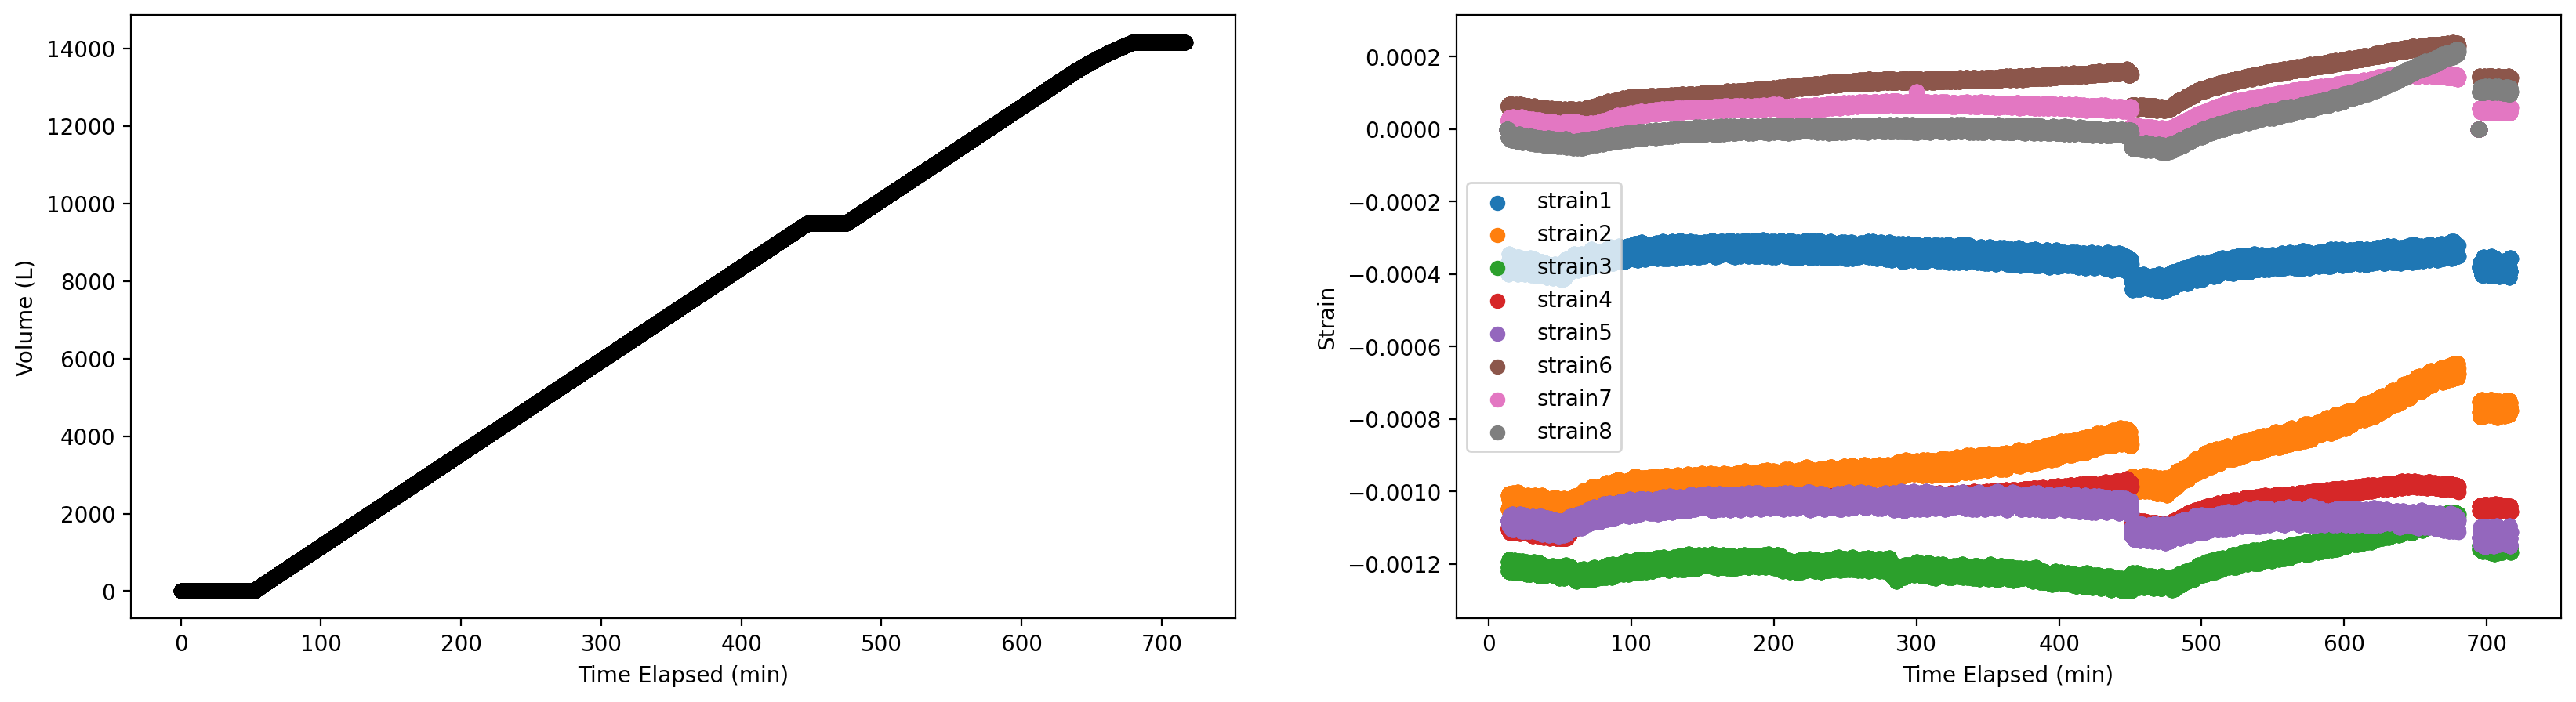

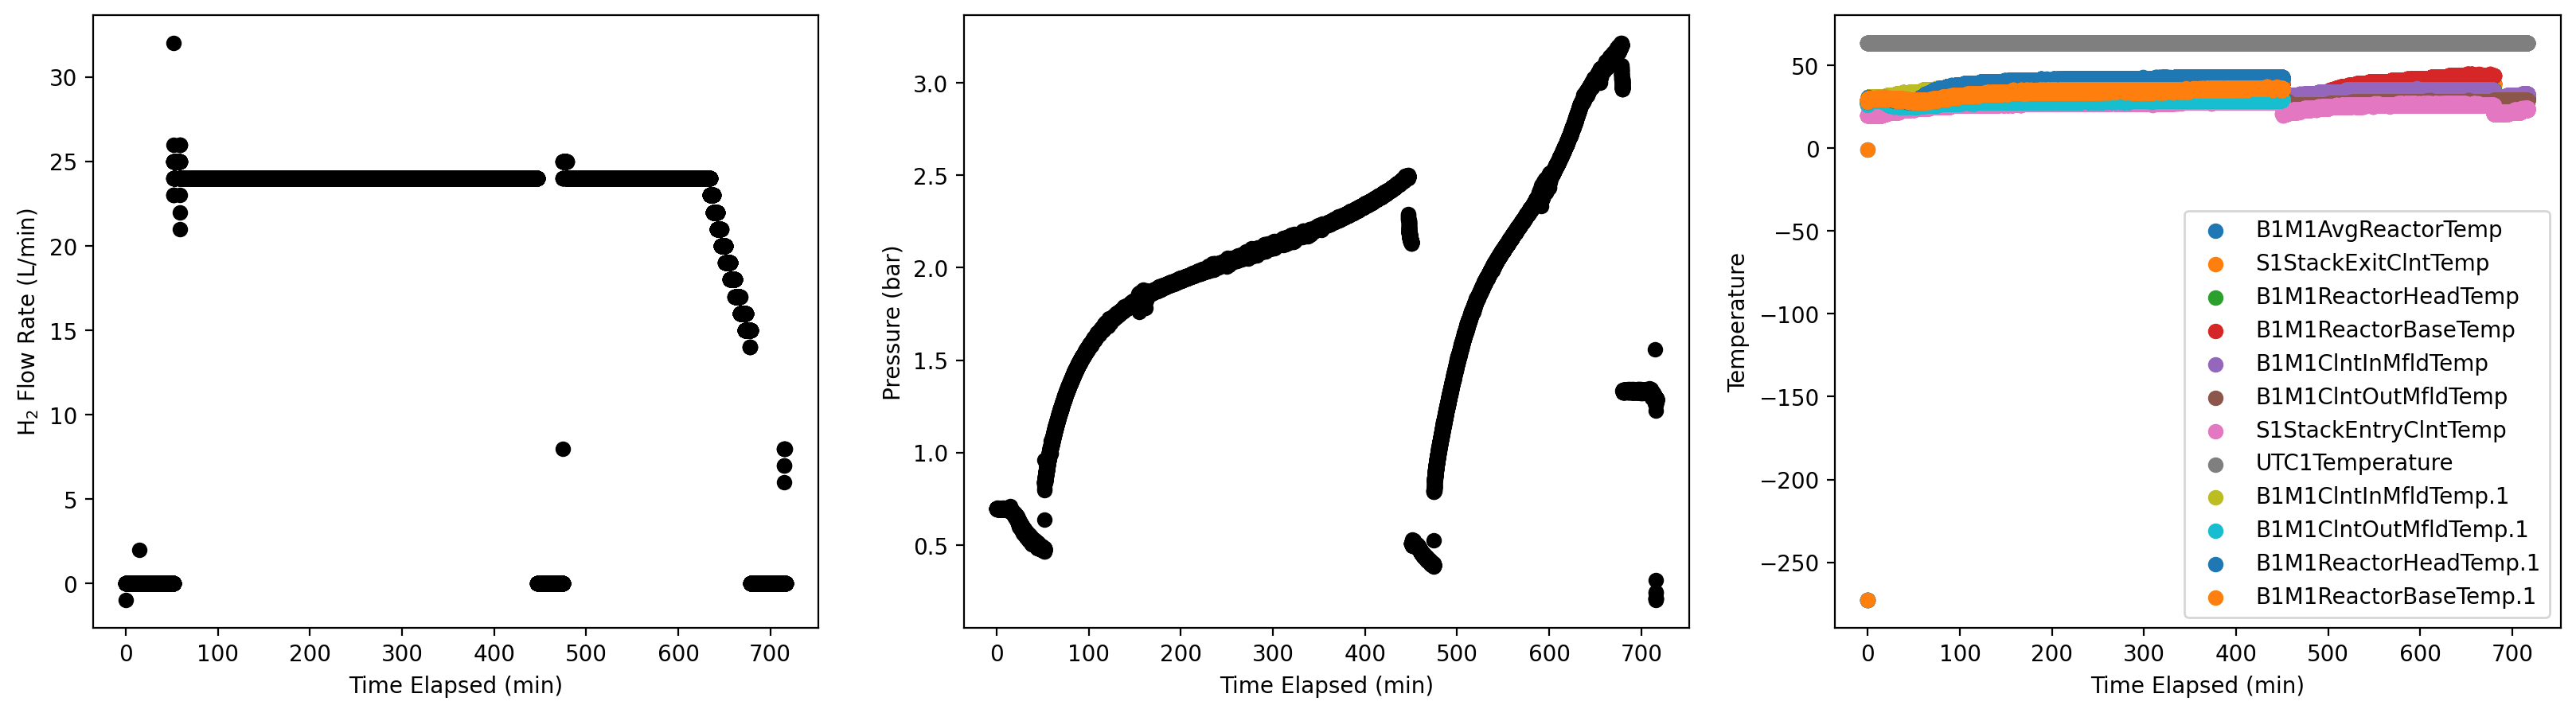

In [8]:
foldersearchpath = 'C:\\Users\\Sebastiano Gadolini\\Documents\\Python Scripts\\HyTEST_Beta2_DataAnalysis\\absorb-beta4-100724\\'

df_strain = process_strain_files(foldersearchpath)
df_HyTEST = process_HyTEST_files(foldersearchpath)
df_full = merge_dataframes(df_HyTEST, df_strain)
df_full = process_data(df_full)
create_and_view_plots(df_full)

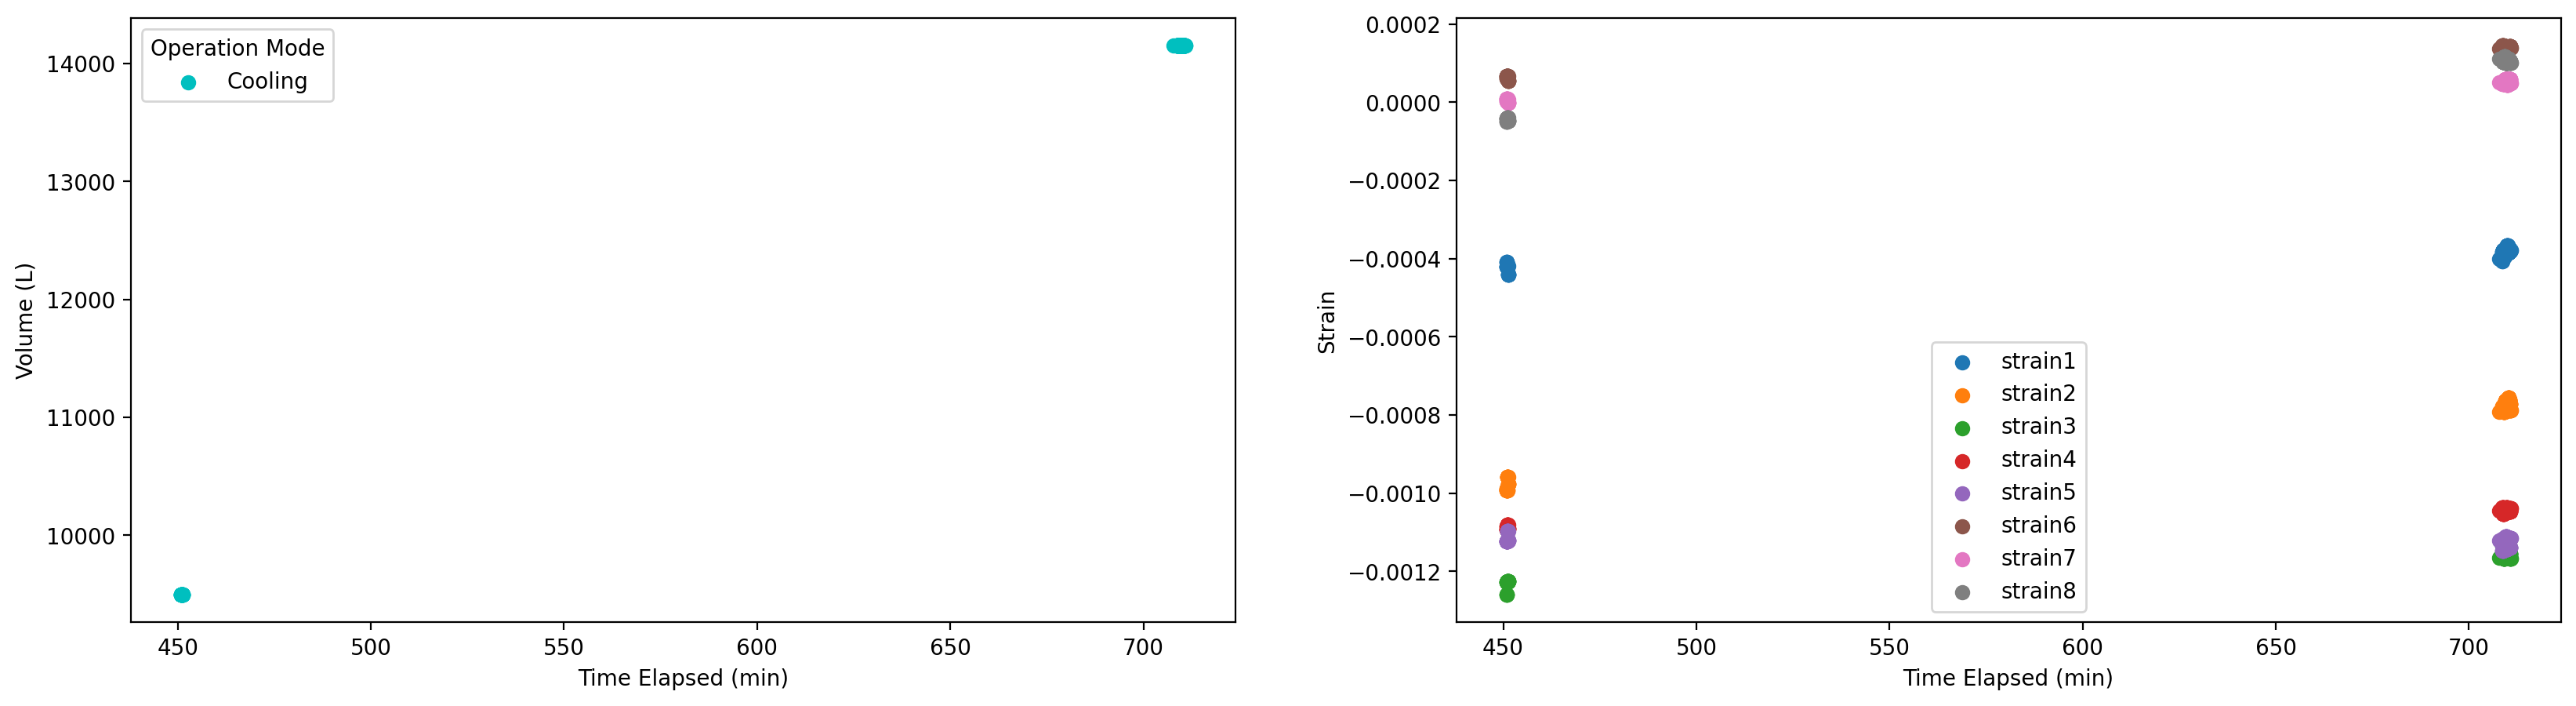

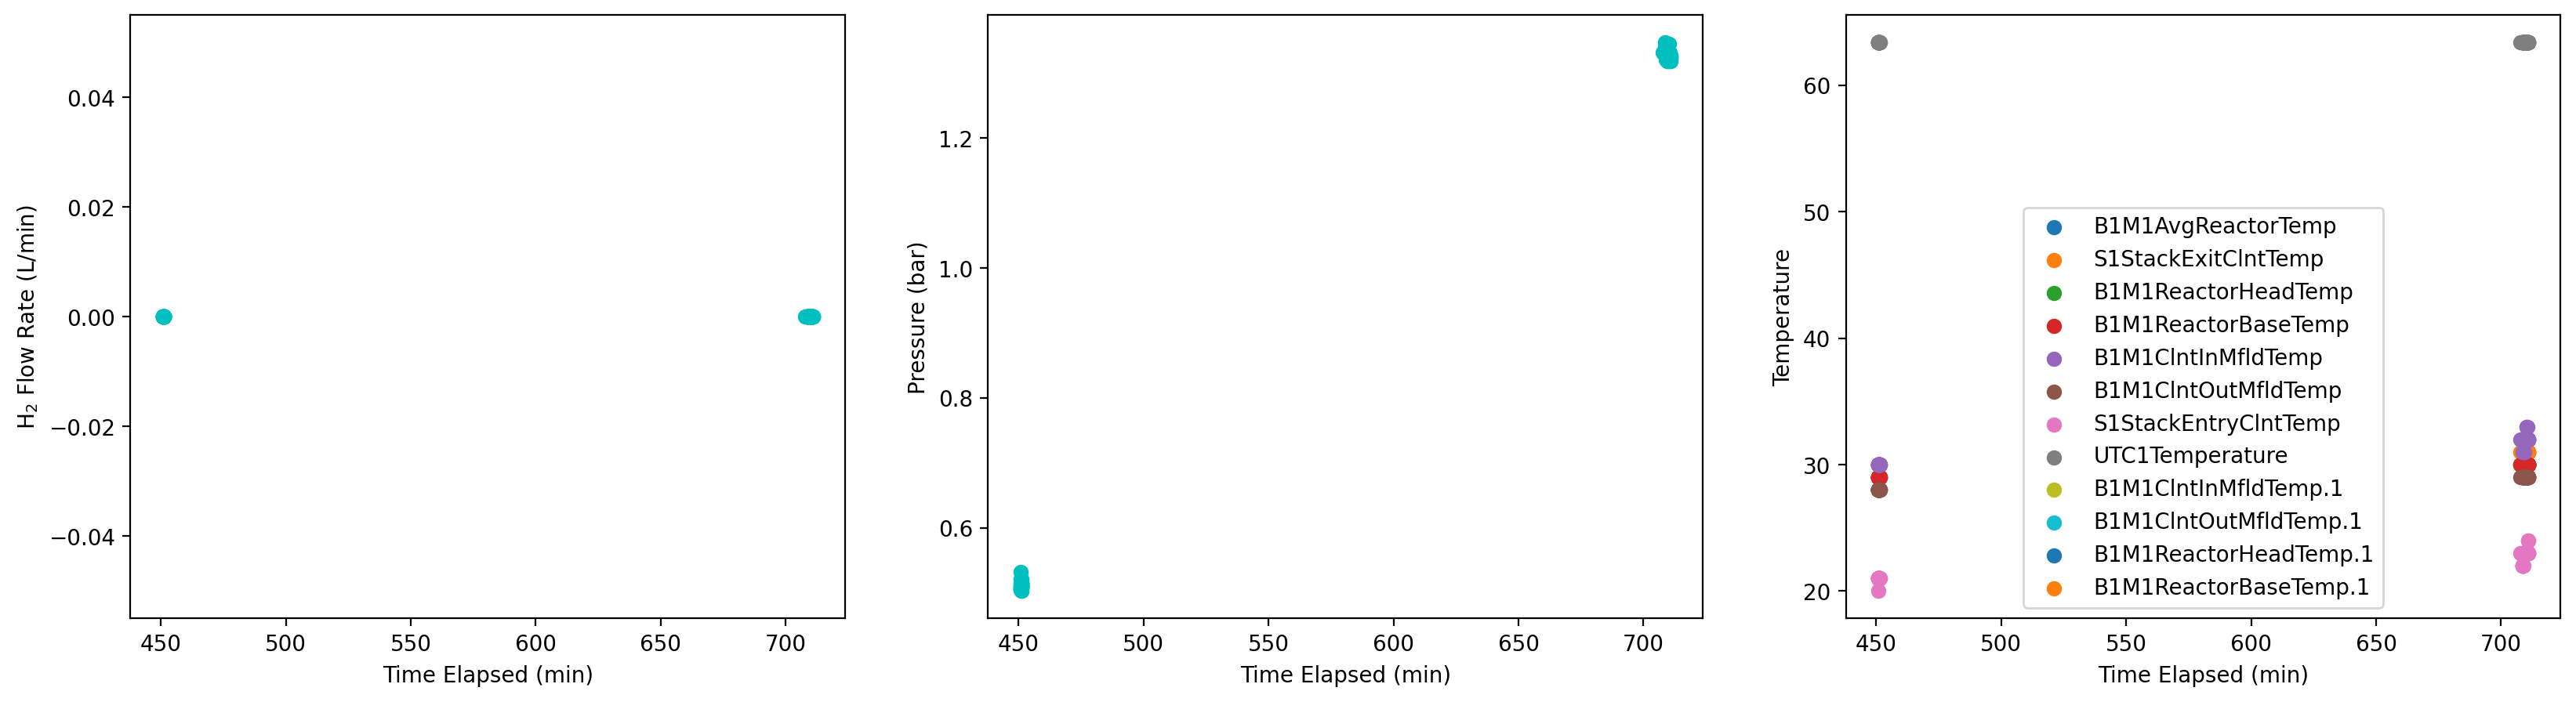

In [9]:
#df_cooling = extract_data_for_opmode(df_full, OpMode_id=4)
create_and_view_plots(df_full, OpMode_id=4)

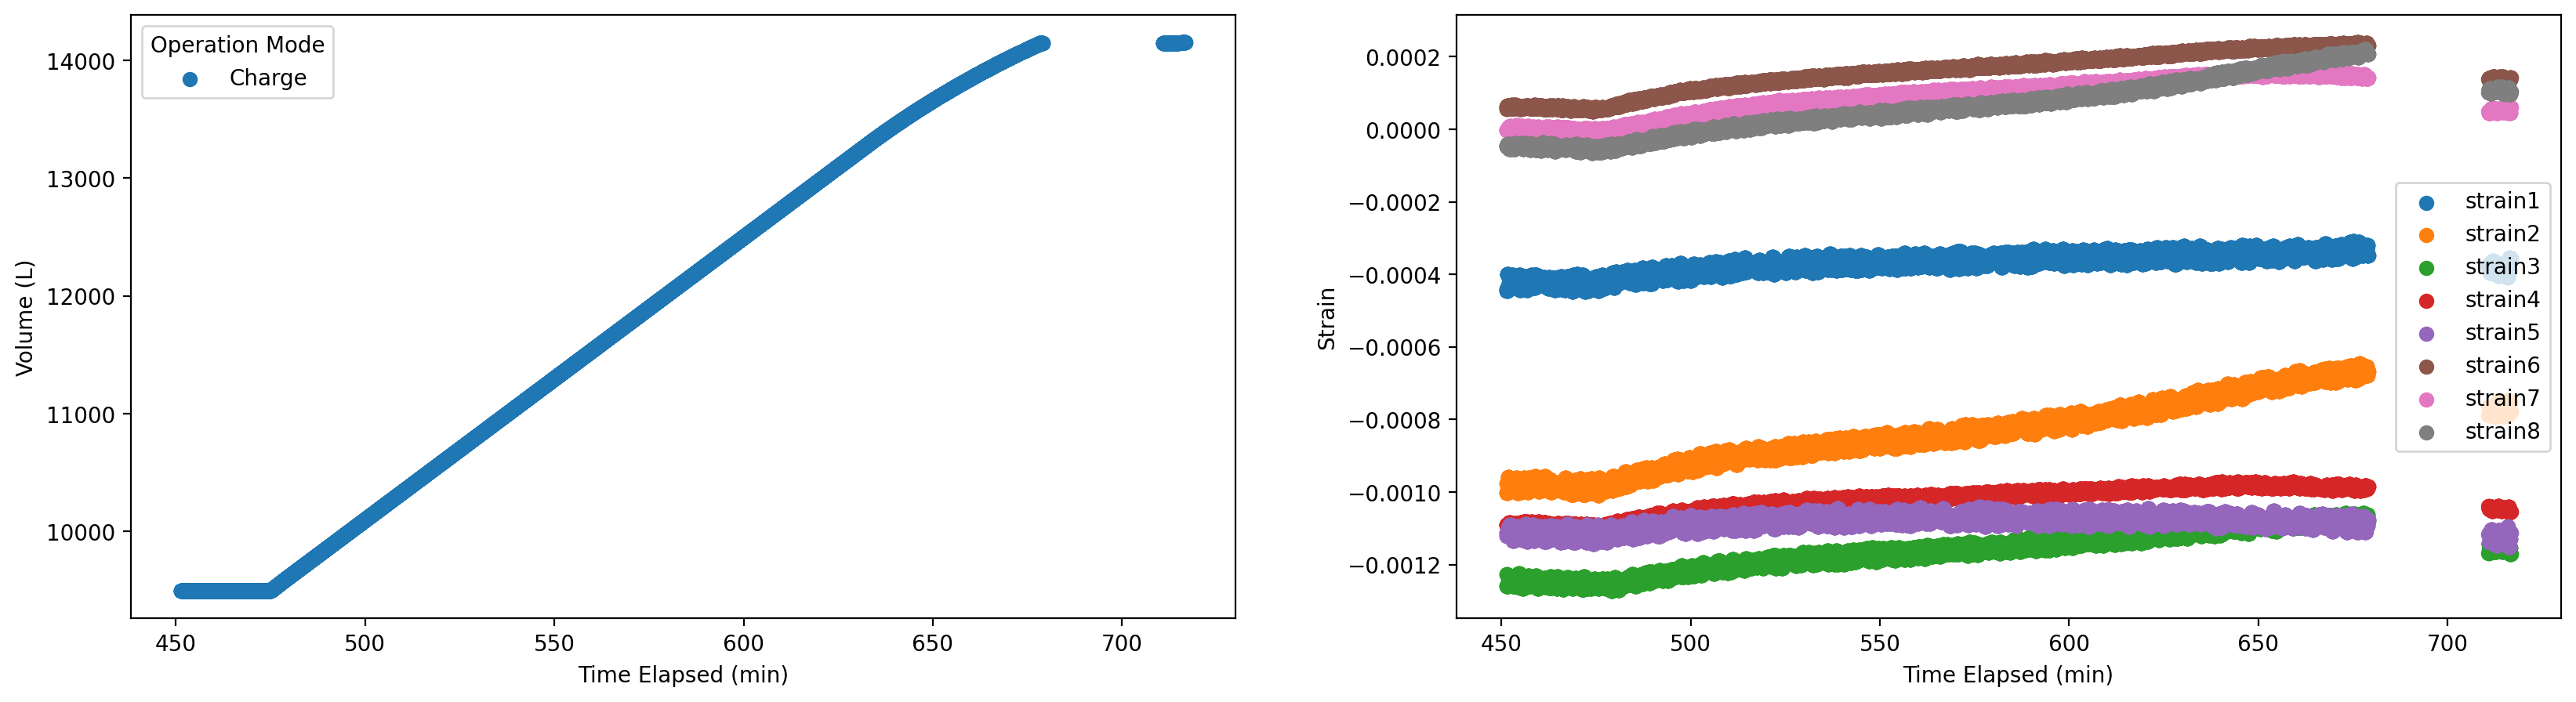

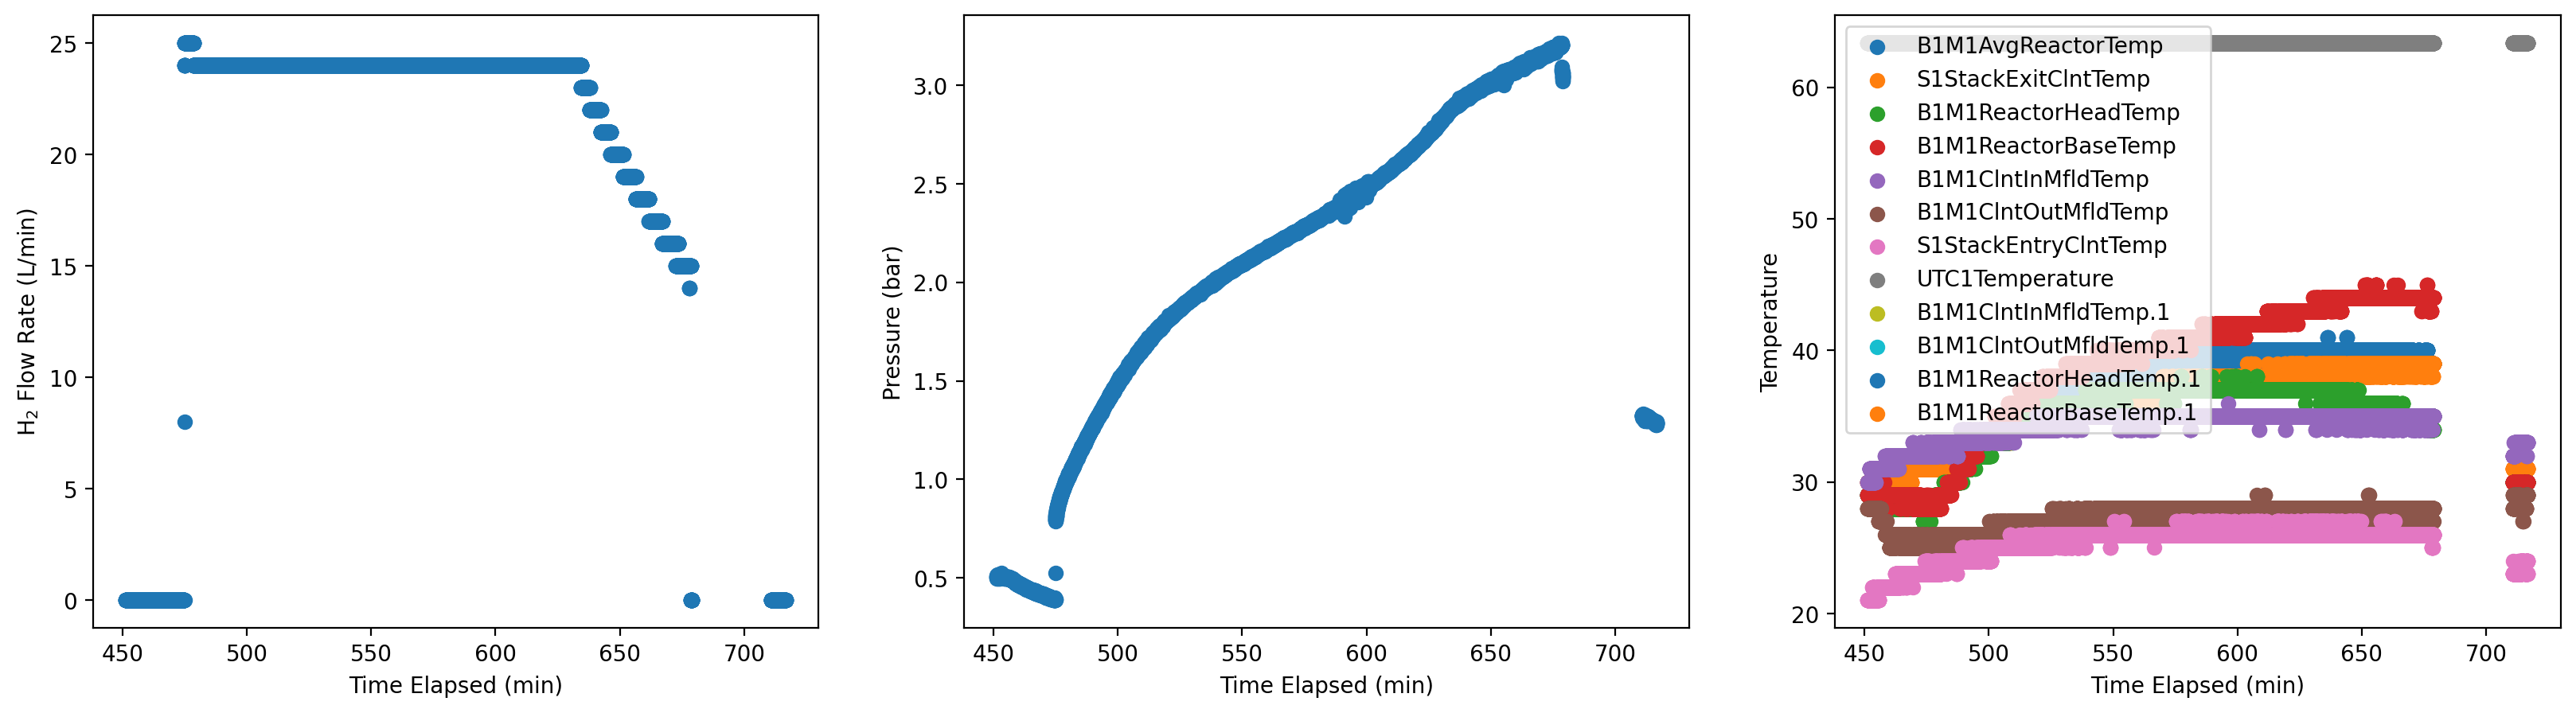

In [10]:
#df_absorption = extract_data_for_opmode(df_full, OpMode_id=5)
create_and_view_plots(df_full, OpMode_id=5)

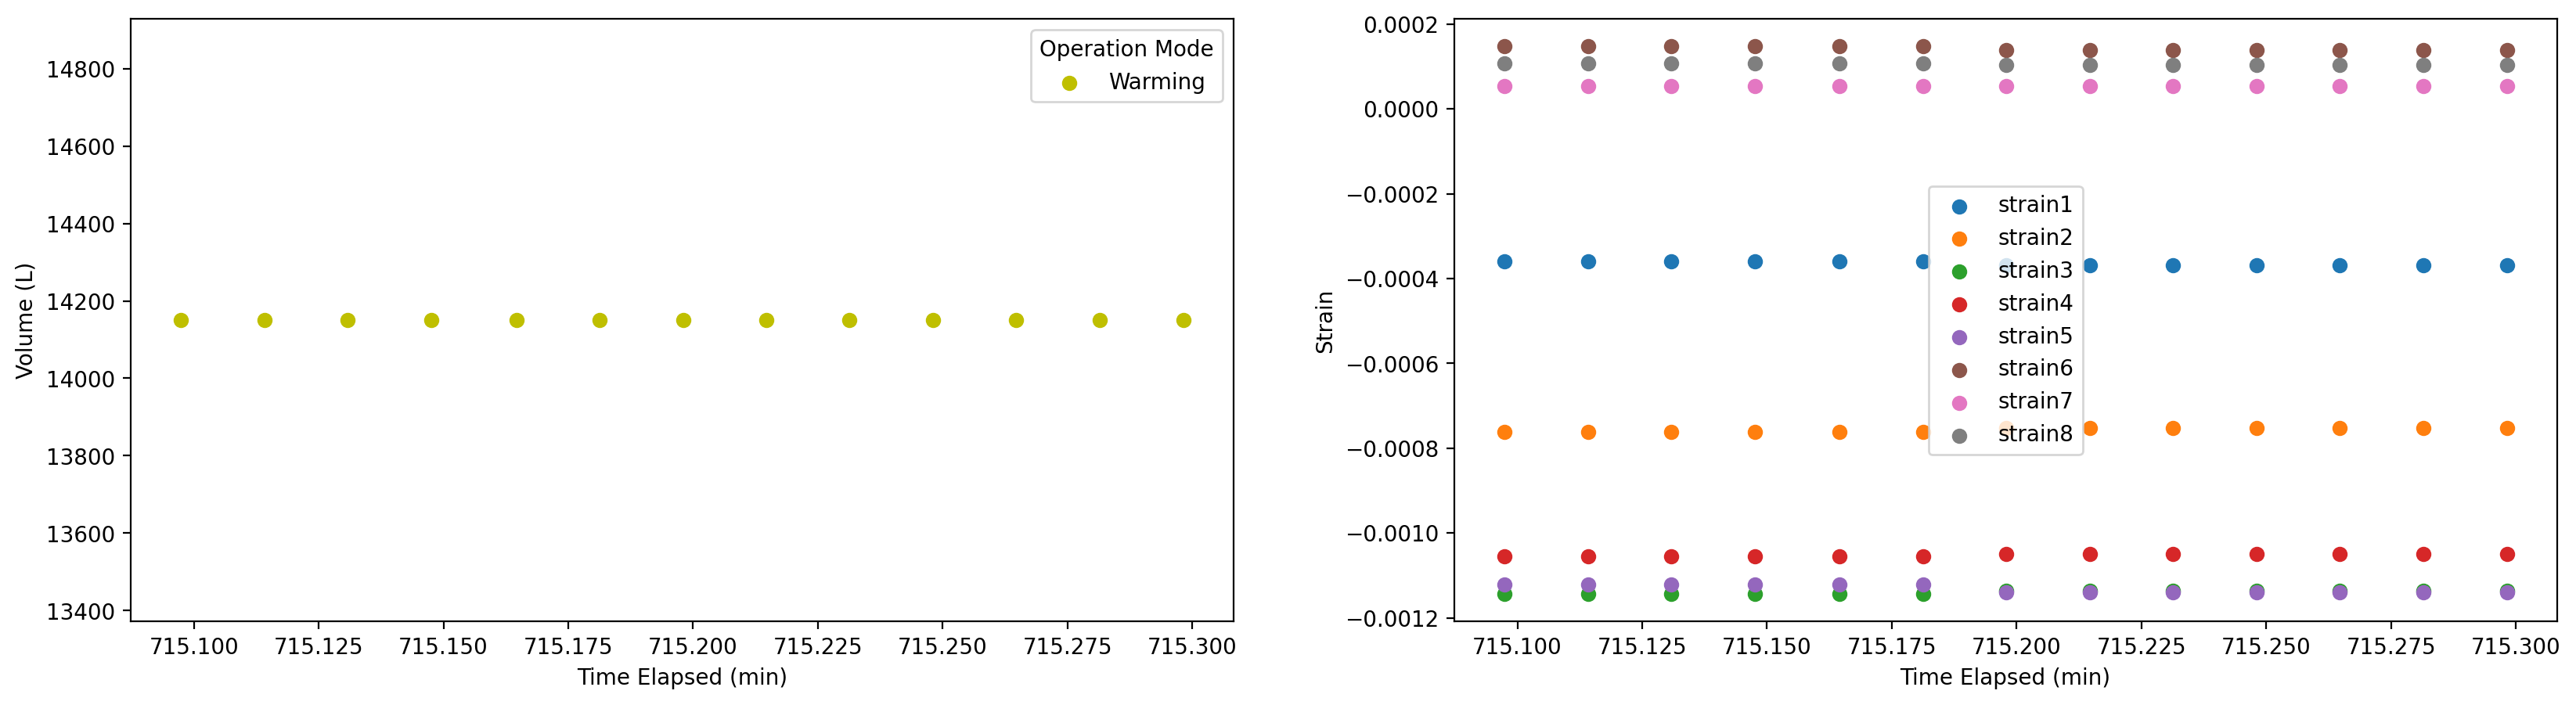

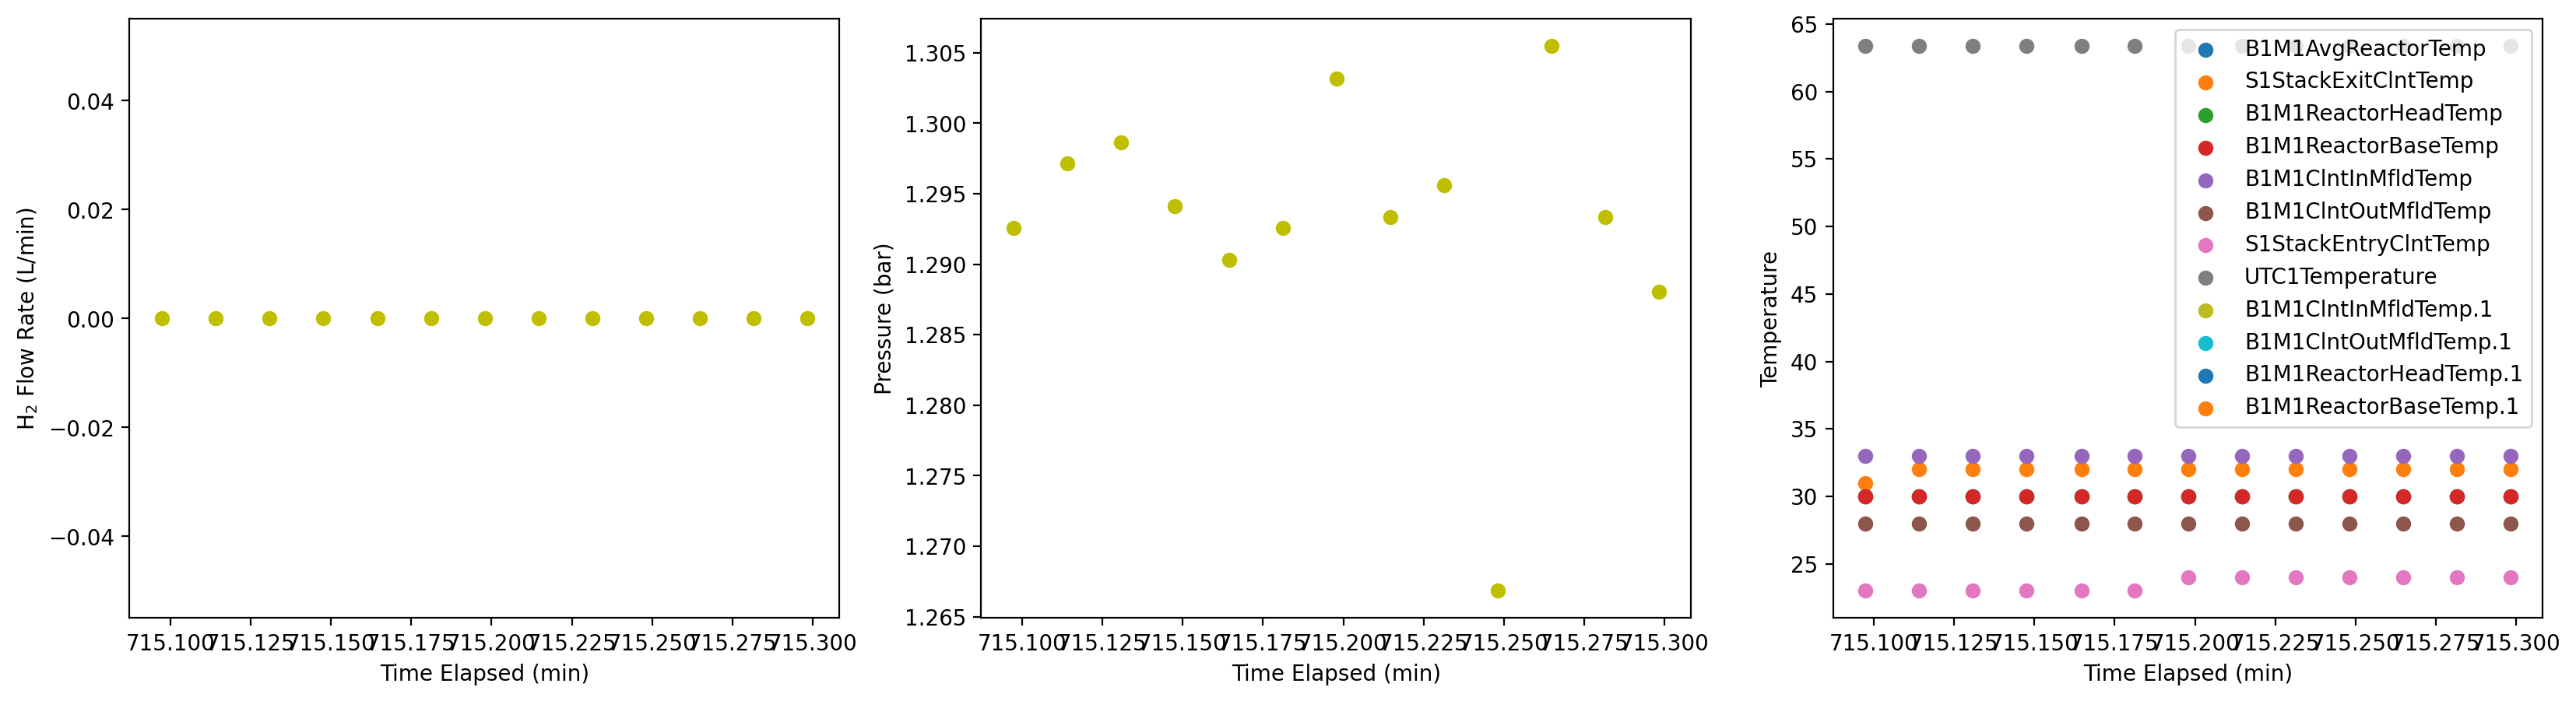

In [11]:
df_warming = extract_data_for_opmode(df_full, OpMode_id=6)
create_and_view_plots(df_full, OpMode_id=6)

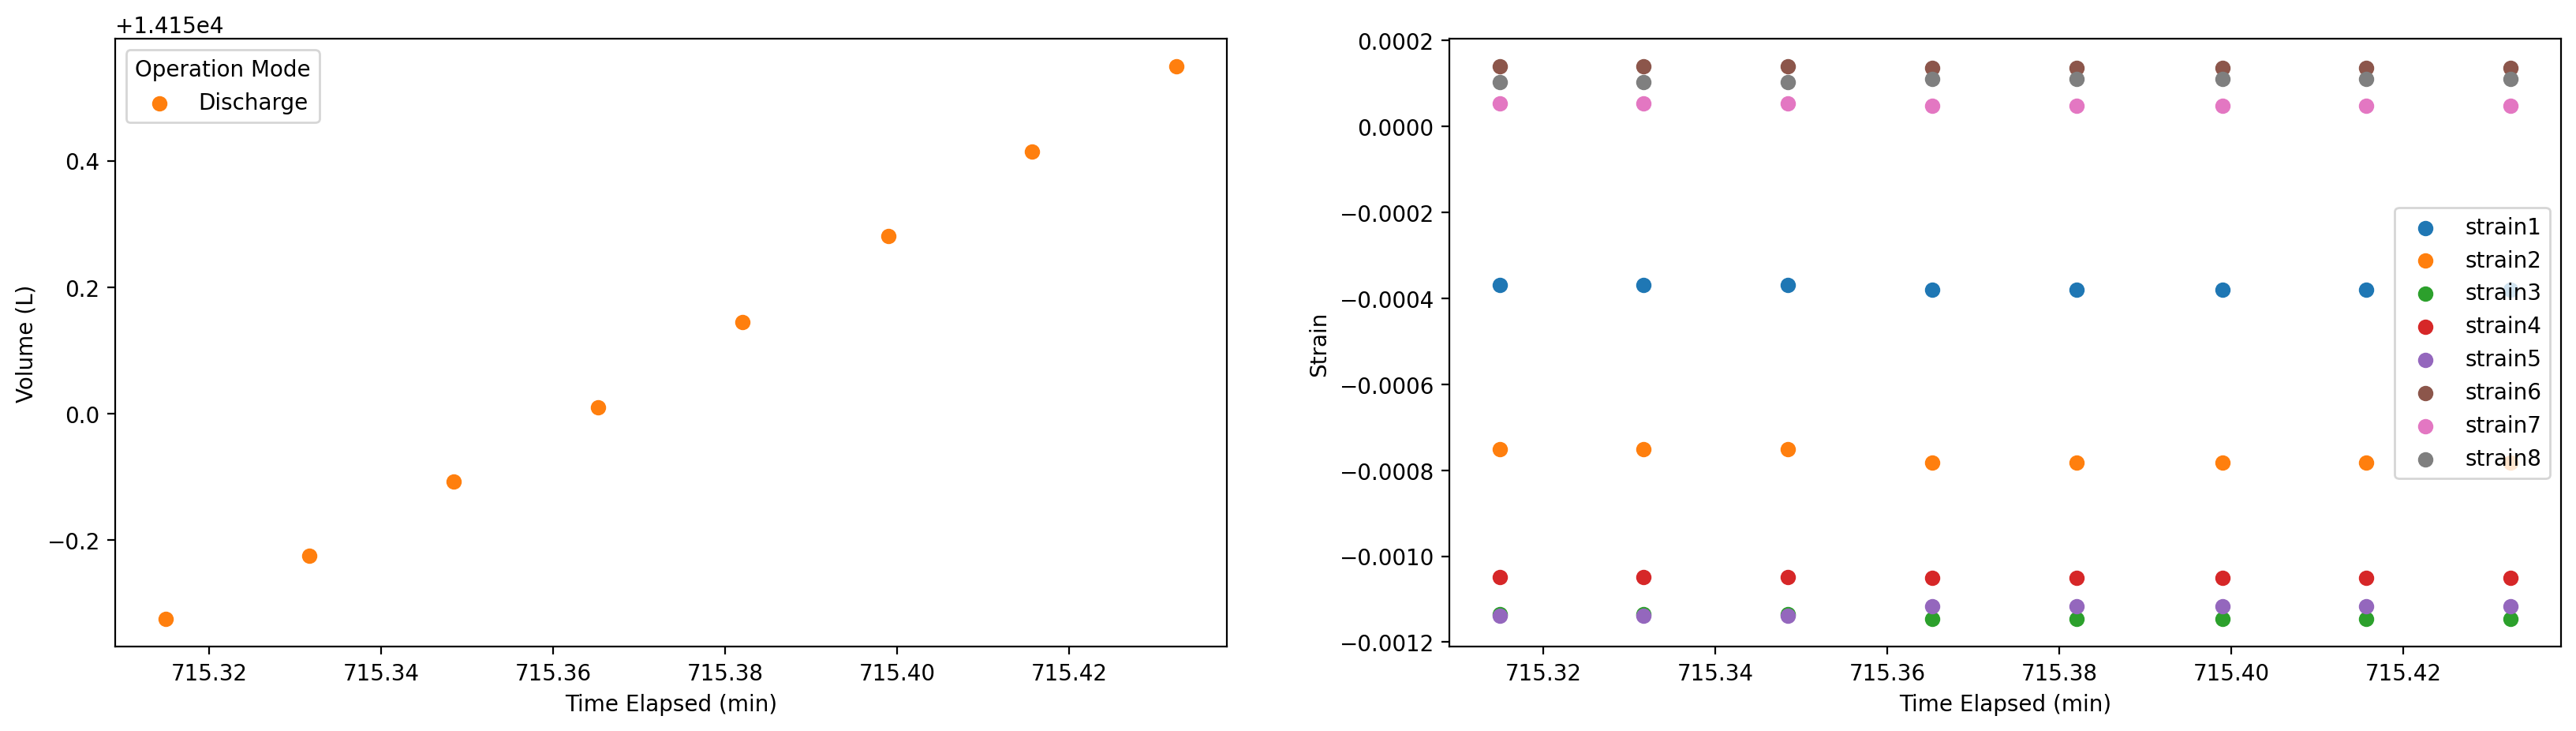

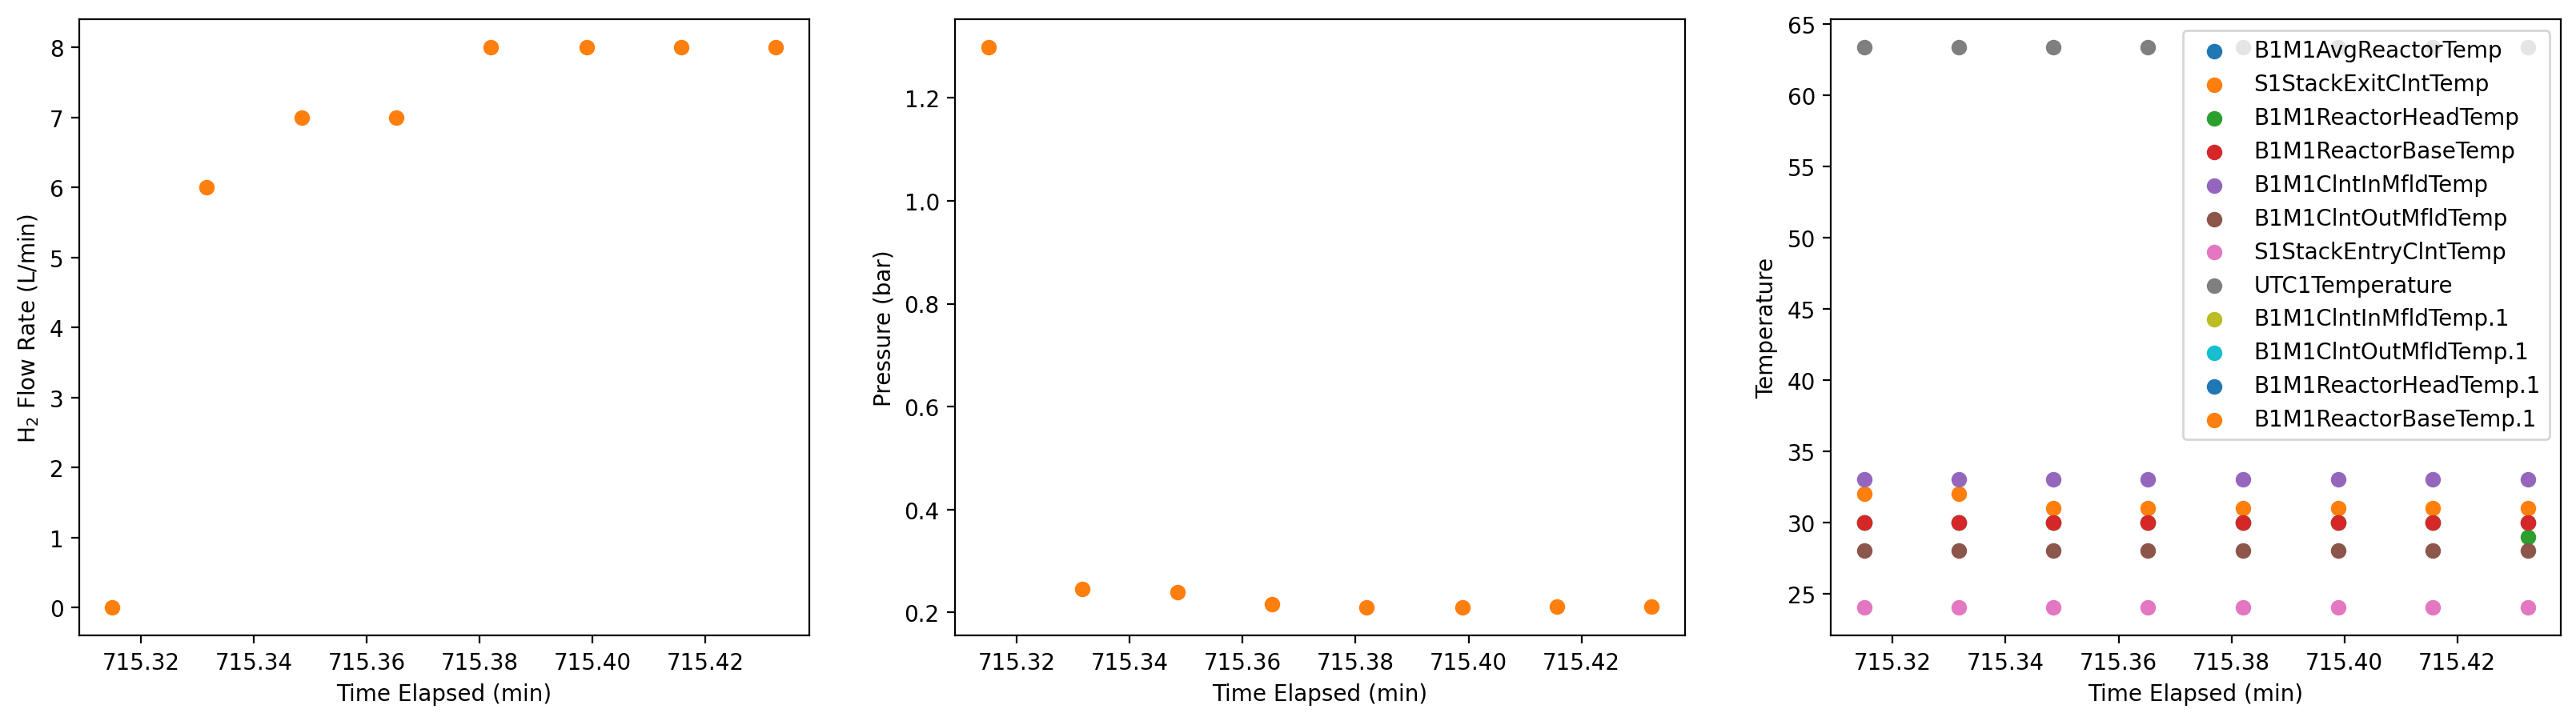

In [12]:
#df_desorption = extract_data_for_opmode(df_full, OpMode_id=7)
create_and_view_plots(df_full, OpMode_id=7)

# Save